## 4 - Packed Padded Sequences, Masking, Inference and BLEU

> Trong notebook này, chúng ta sẽ cải tiến model ở notebook trước - áp dụng packed padded sequences và masking. Packed padded sequences có chức năng thông báo cho RNN biết và bỏ qua các padding tokens trong encoder. Trong khi đó, masking "ép" model ignore những giá trị cụ thể - ví dụ như attention score của các padded elements. Cả 2 kỹ thuật trên (packed padded sequences và masking) đều được sử dụng khá phổ biến trong NLP.

> Bên cạnh đó, chúng ta cũng xây dựng cách mô hình dự đoán - đầu vào là một câu, đầu ra sẽ là câu được dịch ở ngôn ngữ khác, đồng thời ta có thể quan sát điểm attention khi dịch mỗi từ.

> Cuối cùng, ta sẽ sử dụng BLEU metric để đánh giá chất lượng model dịch.

### Preparing Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

> Import spacy và định nghĩa German và English tokenizers.

In [3]:
import spacy

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

> Khi sử dụng *packed padded sequences*, chúng ta cần thông báo với PyTorch độ dài thực (non-padded) của sequences là gì. May mắn thay, trường `Field` trong TorchText cho phép ta sử dụng đối số `include_lengths` và chuyển `batch.src` thành một tupple với: phần tử đầu tiên trong tupple là một batch các source sentences đã được số hóa dưới dạng tensor, và phần tử thứ 2 là chiều dài thực (non-padded) của mỗi source sentence trong batch.

In [5]:
SRC = Field(tokenize = tokenize_de,
            init_token='',
            eos_token='',
            lower = True,
            include_lengths=True)

TRG = Field(tokenize = tokenize_en,
            init_token='',
            eos_token='',
            lower = True,
            include_lengths=True)

> Load data.

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

> Build Vocabulary.

In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

> Tiếp theo, chúng ta xử lý iterators.

> Một điểm khá mơ hồ về *packed padded sequences* là tất cả các phần tử trong batch cần được sắp xếp bởi chiều dài thực của câu (non-padded lengths) theo thứ tự giảm dần. Ta sẽ sử dụng 2 đối số trong iterator để xử lý vấn đề này: `sort_with_batch` thông báo cho iterator biết nội dung trong batch cần được sắp xếp, và `sort_key` là một hàm xác định cách mà iterator sắp xếp các elements trong batch. Cụ thể trong trường hợp này, ta sắp xếp theo chiều dài của source sentence, `src`.

In [8]:
BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator =\
    BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src))

In [9]:
# test data
for i, batch in enumerate(train_iterator):
    src, src_len = batch.src
    trg, trg_len = batch.trg
    print("src shape:", src.shape)
    print("src len:", src_len)
    print("trg shape:", trg.shape)
    print("trg len:", trg_len)
    break

src shape: torch.Size([12, 16])
src len: tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12])
trg shape: torch.Size([17, 16])
trg len: tensor([14, 14, 13, 15, 13, 13, 15, 12, 11, 12, 13, 13, 17, 13, 13, 13])


### Building the Model

##### Encoder

> Tiếp theo, ta xây dựng encoder.

> So với model trước, model lần này chỉ có chút thay đổi trong `forward` method. Bây giờ, nó nhận 2 đối số là: chiều dài sentence và sentence thay vì 1 đối số như trước.

> Sau khi soure sentence (sẽ được tự động đệm trong iterator) được embedded, chúng ta có thể sử dụng `pack_padded_sequence` lên nó cùng với chiều dài thực của mỗi câu. Lưu ý là tensor chứa chiều dài của câu phải được chuyển về CPU. Sau đó, `packed_embedded` sẽ là *packed padded sequence* và được đưa vào RNN như bình thường. RNN sẽ trả về 2 đại lượng:  `packed_outputs` - một packed tensor chứa tất cả các hidden states từ sequence, và `hidden` - là final hidden state từ sequence. `hidden` là một tensor chuẩn và không được packed, điểm khác biệt duy nhất là input là một packed sequence, tensor này thu được từ một **non-padded element** trong sequence.

> Sau đó, ta sẽ unpack `packed_outputs` với `pad_paced_sequence` - thứ sẽ trả về `outputs` và chiều dài của chúng (mỗi output có 1 chiều dài).

> Dimension đầu tiên trong `outputs` là chiều dài của padded sequence, tuy nhiên ta sử dụng *packed padded sequence* nên giá trị của các tensors đầu tiên trong `outputs` bằng 0.

In [10]:
class Encoder(nn.Module):
    def __init__(self,
                input_dim, 
                emb_dim, 
                enc_hid_dim, 
                dec_hid_dim, 
                dropout):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)


    def forward(self, src, src_len):

        # src = [src len, batch size]
        # src_len = [batch size]

        embedded = self.dropout(self.embedding(src))

        # embedded = [src len, batch size, emb dim]

        # need to pack the sequence to feed to RNN, and put lengths to cpu
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))

        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        # packed_outputs is a packed sequence containing all hidden states
        # hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        # outputs is now a non-packed sequence, all hidden states obtained
        # when the input is a pad token are all zeros
            
        # outputs = [src len, batch size, hid dim * num directions]
        # hidden = [n layers * num directions, batch size, hid dim]
        
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer
        
        # hidden [-2, :, : ] is the last of the forwards RNN 
        # hidden [-1, :, : ] is the last of the backwards RNN
        
        # initial decoder hidden is final hidden state of the forwards and backwards 
        # encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        # outputs = [src len, batch size, enc hid dim * 2]
        # hidden = [batch size, dec hid dim]
        
        return outputs, hidden

##### Attention

> Attetion module dùng để tính attention values của source sentence.

> Ở model trước, chúng ta cho phép attention module "chú ý" tới các padding tokens bên trong source sentence. Tuy nhiên, lần này chúng ta sẽ sử dụng *masking* để buộc attetion module chỉ hoạt động đối với các non-padding elements.

> Bây giờ, `forward` method nhận thêm đầu vào là `mask`. Đây là một tensor có kích thước **[batch size, source sentence length]** với giá trị "1" tương ứng với token trong sentence không phải là padding token còn "0" tương ứng với padding token. Ví dụ, nếu sentence là: ["hello", "how", "are", "you", "?", \<padding>, \<padding>], thì mask sẽ là [1, 1, 1, 1, 1, 0, 0].

> Ta áp dụng mask sau quá trình tính toán attention nhưng trước khi nó được normalized bởi `softmax` function. Việc này được thực hiện bằng cách sử dụng `masked_fill`. Ở đây, `masked_fill` sẽ fill tensor ở mỗi vị trí `mask == 0` là True, fill với giá trị được xác định ở tham số thứ 2 (`-1e10`). Nói cách khác, nó sẽ lấy các attention value chưa được normalized, và thay các giá trị attention của padding tokens bằng `-1e10`. Bởi vì các số này rất nhỏ so với các giá trị khác trong attention vector, chúng sẽ xấp xỉ 0 khi đi qua `softmax` layer, bảo đảm việc không chú ý tới các padding tokens.

In [11]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        # hidden = [batch size, dec hid dim]
        # encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        # repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        # hidden = [batch size, src len, dec hid dim]
        # encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        # energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        # attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

##### Decoder

> Decoder cần có một chút thay đổi. Nó cần nhận các mask trên source sentence và truyền chúng tới attention module. Bên cạnh đó, ta cũng muốn quan sát giá trị attention trong lúc inference nên sẽ trả về attention tensor.

In [12]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]

        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]

        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1) 

##### Seq2Seq

> Model seq2seq cũng cần một vài thay đổi đối với packed padded sequences, masking và inference.

> Chúng ta cần thông báo chỉ số được sử dụng cho pad token và cần truyền source sentence lengths vào `forward` method.

> Ta cũng cần sử dụng pad token index để tạo masks, bằng cách tạo một mask tensor bằng 1 khi source sentence khác pad token. Hàm `create_mask` đảm nhận vai trò này.

> Sequence lengths cũng cần được truyền vào encoder để sử dụng packed padded sequences.

> Attention ở mỗi thời điểm được lưu trữ trong `attentions`.

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the  tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

### Training the Seq2Seq Model

In [14]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

> Khởi tạo tham số cho model.

In [15]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7854, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5892, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5892, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

> Hiển thị số lượng parameters cần phải train.

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,516,612 trainable parameters


> Định nghĩa optimizer và criterion.

> Đối số `ignore_index` trong criterion cần được xác định là các pad token cho target language, không phải source language.

In [17]:
optimizer = optim.Adam(model.parameters())
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

> Tiếp theo, ta định nghĩa training và evaluation loops.

> Do ta đang sử dụng `include_lengths = True` cho source field, `batch.src` là một tuple với first element là tensor đã được số hóa, biểu diễn sentence và second element là tensor chứa chiều dài của mỗi sentence trong batch.

> Model của chúng ta cũng trả về attention vector sau mỗi batch source sentence tại mỗi thời điểm decode. Chúng ta sẽ không sử dụng chúng trong quá trình training/evaluation, tuy nhiên sẽ dùng khi inference.

In [18]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg, trg_len = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg, trg_len = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

> Timing function.

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

> Train model.

In [21]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './models/tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 72m 44s
	Train Loss: 3.848 | Train PPL:  46.918
	 Val. Loss: 3.557 |  Val. PPL:  35.044
Epoch: 02 | Time: 63m 44s
	Train Loss: 2.665 | Train PPL:  14.362
	 Val. Loss: 3.260 |  Val. PPL:  26.056
Epoch: 03 | Time: 63m 54s
	Train Loss: 2.195 | Train PPL:   8.979
	 Val. Loss: 3.195 |  Val. PPL:  24.421
Epoch: 04 | Time: 102m 59s
	Train Loss: 1.882 | Train PPL:   6.569
	 Val. Loss: 3.288 |  Val. PPL:  26.797
Epoch: 05 | Time: 68m 26s
	Train Loss: 1.655 | Train PPL:   5.235
	 Val. Loss: 3.306 |  Val. PPL:  27.279
Epoch: 06 | Time: 72m 10s
	Train Loss: 1.513 | Train PPL:   4.539
	 Val. Loss: 3.418 |  Val. PPL:  30.501
Epoch: 07 | Time: 82m 49s
	Train Loss: 1.407 | Train PPL:   4.085
	 Val. Loss: 3.515 |  Val. PPL:  33.628
Epoch: 08 | Time: 79m 3s
	Train Loss: 1.313 | Train PPL:   3.717
	 Val. Loss: 3.660 |  Val. PPL:  38.875
Epoch: 09 | Time: 79m 30s
	Train Loss: 1.254 | Train PPL:   3.503
	 Val. Loss: 3.737 |  Val. PPL:  41.977
Epoch: 10 | Time: 78m 44s
	Train Loss: 1.207 |

> Load parameters và đánh giá.

In [22]:
model.load_state_dict(torch.load('./models/tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.178 | Test PPL:  24.006 |


> Ta có thể thấy, test perplexity được cải thiện trong khi thời gian train giảm một nửa.

### Inference

> **NOTE:** Quá trình dịch này sẽ hơi noob so với ví dụ trong paper bởi vì họ sử dụng hidden dimension có kích thước 1000 và train trong 4 ngày!

> Hàm `translate_sentence` sẽ thực hiện các công việc sau:
>> * Đảm bảo model ở evaluation mode (inference thì model luôn luôn phải ở chế độ evaluation).
>> * Tokenize source sentece nếu nó chưa được tokenized.
>> * Số hóa source sentence.
>> * Convert source sentence đã được số hóa thành tensor và thêm vào batch dimension.
>> * Lấy chiều dài thực của source sentence và convert thành tensor.
>> * Đưa source sentence vào encoder.
>> * Tạo mask cho source sentence.
>> * Tạo list để lưu trữ output sentence, được khởi tạo với một token \<sos>.
>> * Tạo tensor để lưu trữ attention values.
>> * Lặp khi chưa đạt đến độ dài tối đa:
>>>> * Lấy input tensor.
>>>> * Đưa input, tất cả các encoder outputs, hidden state và mask vào decoder.
>>>> * Lưu trữ attention values.
>>>> * Lấy giá trị dự đoán của token tiếp theo.
>>>> * Thêm giá trị dự đoán vào output sentence prediction.
>>>> * break nếu prediction là \<eos> token.
> * Chuyển output sentence từ indexes sang tokens.
> * Trả về output sentence (sau khi đã removed các \<sos> token) và attention value của mỗi sequence.

In [23]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

> Tiếp theo, ta xây dựng hàm hiển thị attention của model xuyên suốt souce sentence đối với mỗi target token được sinh ra.

In [24]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + [''] + [t.lower() for t in sentence] + ['']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

> Nhặt một vài ví dụ để test.

> Nhặt từ src và trg.

In [25]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['.', 'kämpfen', 'hund', 'gefleckter', 'ein', 'und', 'hund', 'schwarzer', 'ein']
trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


> sử dụng `translate_sentence` để dự đoán và quan sát attention. 

In [26]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'wrestle', '.', '']


> Áp dụng `display_attention` để quan sát attention values.

c:\Users\longln3\Anaconda3\envs\python3.7.6\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
c:\Users\longln3\Anaconda3\envs\python3.7.6\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  


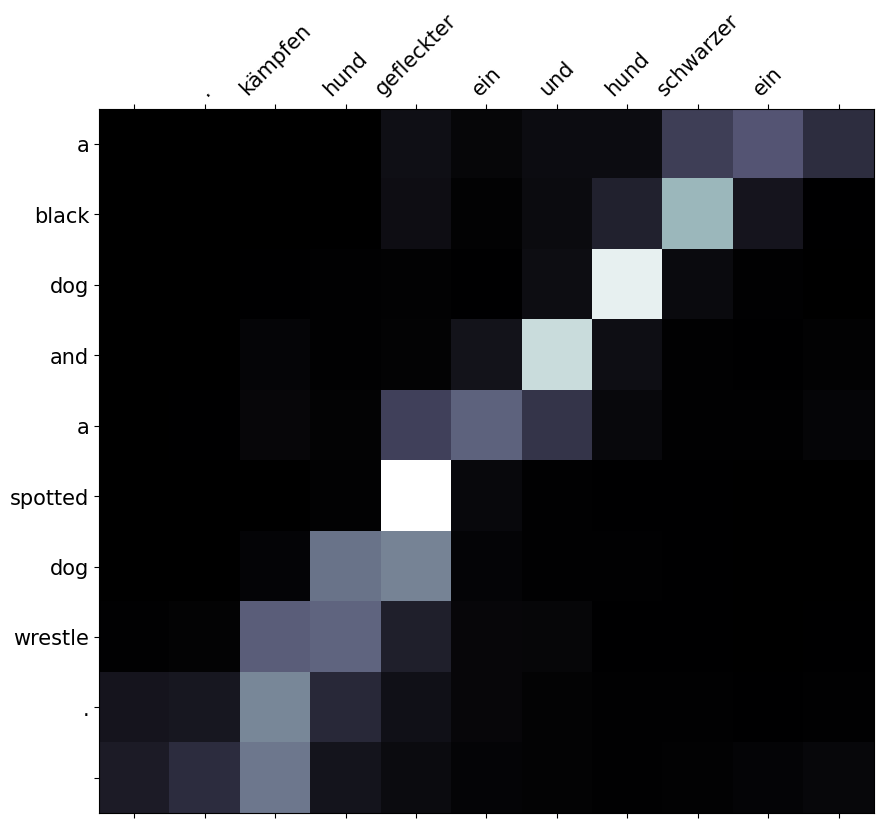

In [27]:
display_attention(src, translation, attention)

> Ở hình trên ta có, trục x là source sentence, trục y là predicted translation. Những phần ô vuông màu sáng biểu thị mức độ chú ý của model tới từ trong source sentence khi dịch từ trong target sentence.

> Kiểm tra trên tập validation.

In [28]:
example_idx = 14

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['.', 'geige', 'ihrer', 'auf', 'lied', 'ein', 'spielt', 'frau', 'eine']
trg = ['a', 'female', 'playing', 'a', 'song', 'on', 'her', 'violin', '.']


> Quan sát attention values.

predicted trg = ['a', 'woman', 'playing', 'a', 'a', 'song', 'on', 'her', 'violin', '.', '']


c:\Users\longln3\Anaconda3\envs\python3.7.6\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
c:\Users\longln3\Anaconda3\envs\python3.7.6\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  


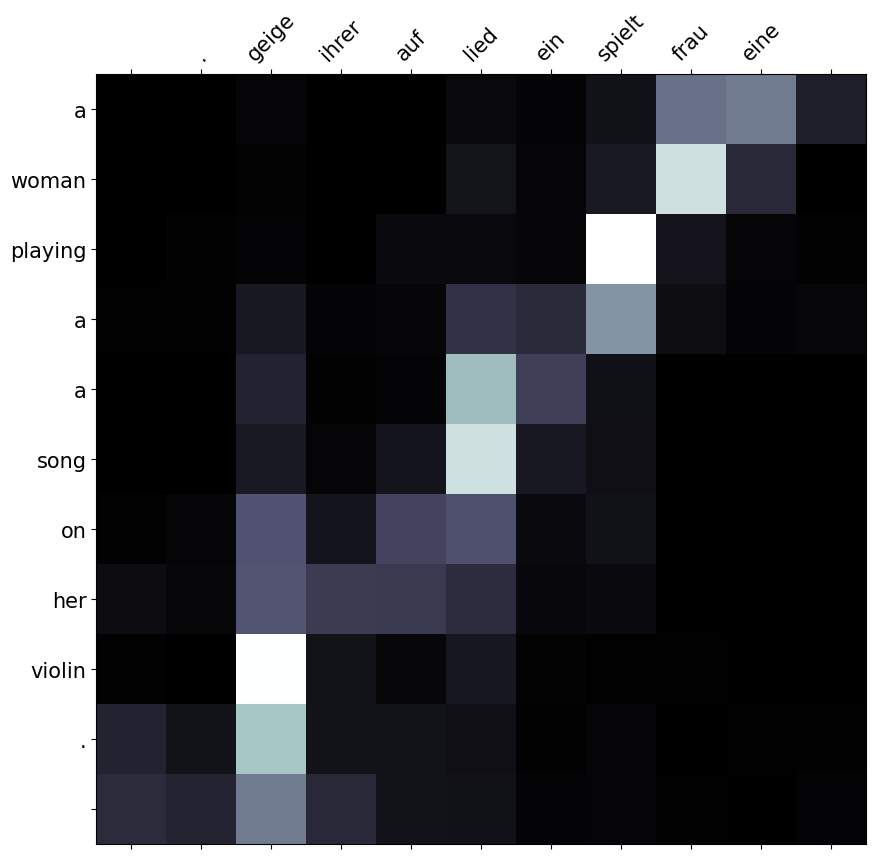

In [29]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

> Áp dụng trên test set.

In [30]:
example_idx = 18

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['.', 'berg', 'einen', 'auf', 'klettert', 'shirt', 'gestreiften', 'im', 'person', 'die']
trg = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'mountain', 'climbing', '.']


predicted trg = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'climbing', 'mountain', 'mountain', '.', '']


c:\Users\longln3\Anaconda3\envs\python3.7.6\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
c:\Users\longln3\Anaconda3\envs\python3.7.6\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  


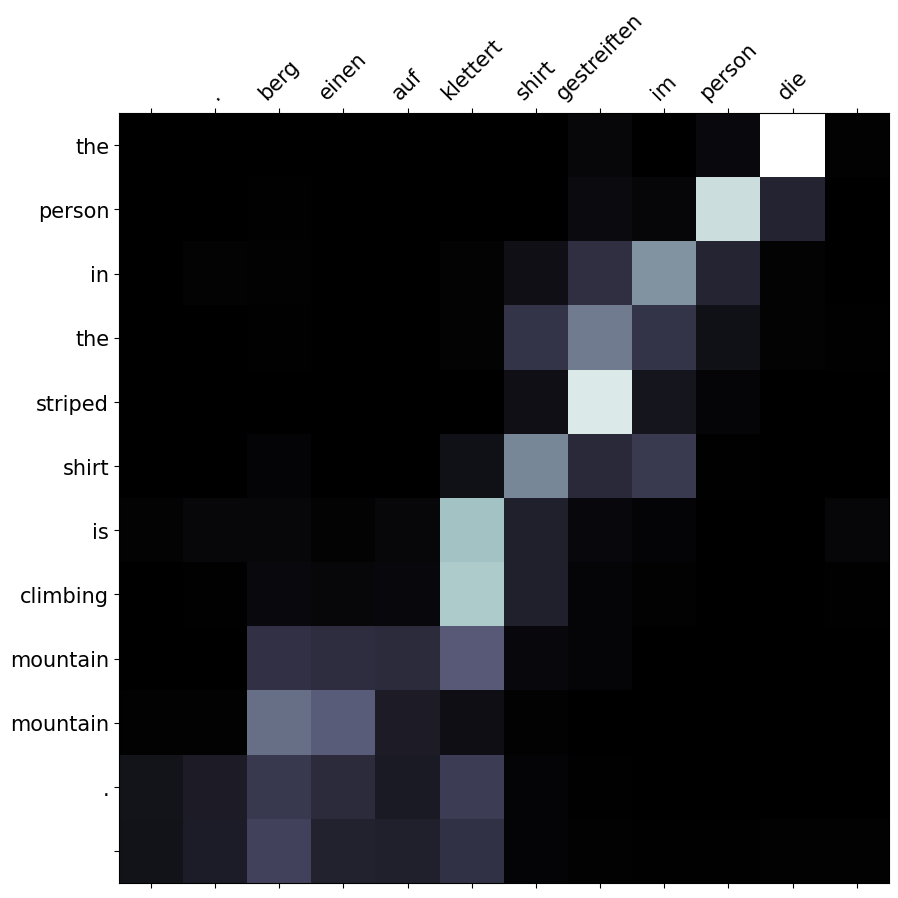

In [31]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

### BLEU

> Trước đây, ta chỉ quan tâm tới loss/perplexity của model. Tuy nhiên có một phép đo được thiết kế riêng cho bài toán dịch máy và thường được sử dụng, đó là *BLEU*. Notebook này sẽ không đi chi tiết về BLEU (nhấn vào [đây](https://machinelearninginterview.com/topics/natural-language-processing/bleu-score/) để hiểu về BLEU). Về cơ bản, BLEU sẽ quan sát trùng lặp giữa predicted và actual target sequences theo n-grams. Nó cho chúng ta một số giữa 0 và 1 đối với mỗi sequence, và 1 tương ứng với perfect overlap, perfect translation. BLEU được thiết kế cho việc dịch nhiều câu nguồn, tuy nhiên trong dataset này, ta chỉ có một câu nguồn.

> Ta định nghĩa hàm `calculate_bleu` để tính BLEU score. hàm này tạo một corpus của actual và predicted translation đối với mỗi source sentence, sau đó tính BLEU score.

In [32]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off  token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

> Model trong notebook này đạt giá trị BLEU khoảng 28. Thực ra điểm BLEU này không nói lên được nhiều điều. Nó thường được dùng để đánh giá 2 model trên cùng dataset. Model có BLEU cao hơn thì sẽ tốt hơn.

In [33]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 31.84


> Ở tutorial tiếp theo, chúng ta sẽ tạm chia tay RNN và xây dựng seq2seq model theo hướng khác - sử dụng Convolutional Neural Networks (CNN).

## END